# Imports

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.serialize import model_to_json
from prophet.plot import *

import time # para medir o tempo de execução
import itertools # para iterar sobre todos os parâmetros

# salvar modelos
import json
import pickle

import tqdm as notebook_tqdm

# warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utils import *

# Modelo Baseline

In [4]:
# importar dados
df_baseline = pd.read_parquet(r'data\baseline_data.parquet')

df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9649 entries, 1987-05-20 to 2024-05-13
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            9649 non-null   object 
 1   year             9649 non-null   object 
 2   weekday          9649 non-null   object 
 3   is_weekday       9649 non-null   int32  
 4   is_holiday       9649 non-null   int32  
 5   is_holiday_week  9649 non-null   int32  
 6   sp500            9649 non-null   float64
 7   exxon            9649 non-null   float64
 8   bp               9649 non-null   float64
 9   brent            9649 non-null   float64
 10  brent_diff       9648 non-null   float64
 11  brent_pct        9648 non-null   float64
 12  nasdaq_diff      9648 non-null   float64
 13  nasdaq_pct       9648 non-null   float64
 14  sp500_diff       9648 non-null   float64
 15  sp500_pct        9648 non-null   float64
 16  exxon_diff       9648 non-null   float64
 

In [5]:
# remover colunas de 0 a 6
df_baseline.drop(df_baseline.columns[0:6], axis=1, inplace=True)

df_baseline.shape

(9649, 14)

In [6]:
# remover todas as colunas com NaN (diferenças e percentuais de mudança)
df_baseline.dropna(axis=1, inplace=True)

df_baseline.shape

(9649, 4)

In [7]:
baseline_regressors = [col for col in df_baseline.columns if col != 'brent']

baseline_regressors = df_baseline[baseline_regressors].copy()

baseline_regressors

,sp500,exxon,bp
date,,,
1987-05-20,278.209991,10.921875,18.500000
1987-05-21,280.170013,10.906250,18.687500
1987-05-22,282.160004,10.843750,18.468750
1987-05-25,289.109985,10.984375,18.500000
1987-05-26,289.109985,10.984375,18.500000
...,...,...,...
2024-05-07,5187.700195,116.169998,37.580002
2024-05-08,5187.669922,116.150002,37.529999
2024-05-09,5214.080078,118.440002,38.040001


In [8]:
df_baseline = transform_prophet(df_baseline,
                                y='brent',
                                regressors=baseline_regressors)

df_baseline

,ds,y,sp500,exxon,bp
0,1987-05-20,18.63,278.209991,10.921875,18.500000
1,1987-05-21,18.45,280.170013,10.906250,18.687500
2,1987-05-22,18.55,282.160004,10.843750,18.468750
3,1987-05-25,18.60,289.109985,10.984375,18.500000
4,1987-05-26,18.63,289.109985,10.984375,18.500000
...,...,...,...,...,...
9644,2024-05-07,82.69,5187.700195,116.169998,37.580002
9645,2024-05-08,82.44,5187.669922,116.150002,37.529999
9646,2024-05-09,83.27,5214.080078,118.440002,38.040001
9647,2024-05-10,83.39,5222.680176,117.959999,37.840000


In [9]:
# train test split -> 80% treino e 20% teste
baseline_train_size = int(len(df_baseline) * 0.8)

baseline_train = df_baseline.iloc[:baseline_train_size].copy()
baseline_test = df_baseline.iloc[baseline_train_size:].copy()

print(f'Treino: {len(baseline_train)}')
print(f'Teste: {len(baseline_test)}')

# save train and test data
baseline_train.to_parquet(r'data\prophet_baseline_train.parquet')
baseline_test.to_parquet(r'data\prophet_baseline_test.parquet')

Treino: 7719
Teste: 1930


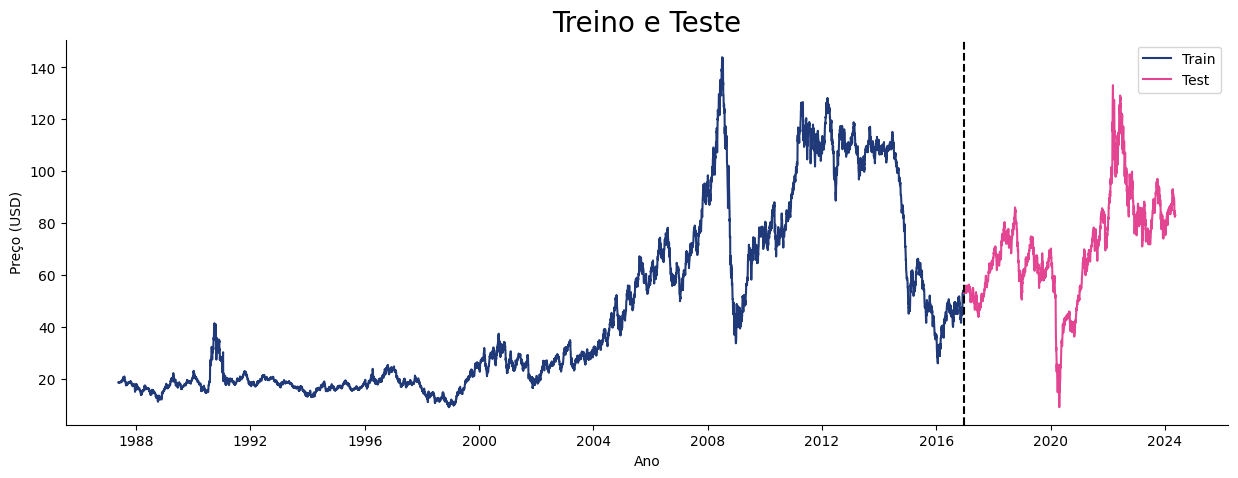

In [10]:
# plot train and test
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(baseline_train['ds'], 
        baseline_train['y'], 
        label='Train', color='#1f3979')
ax.plot(baseline_test['ds'], 
        baseline_test['y'], 
        label='Test', 
        color='#e34592')
ax.set_title('Treino e Teste', fontsize=20)
ax.set_xlabel('Ano')
ax.set_ylabel('Preço (USD)')
ax.axvline(x=baseline_test['ds'].min(), color='black', linestyle='--')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend();

11:46:28 - cmdstanpy - INFO - Chain [1] start processing
11:46:30 - cmdstanpy - INFO - Chain [1] done processing


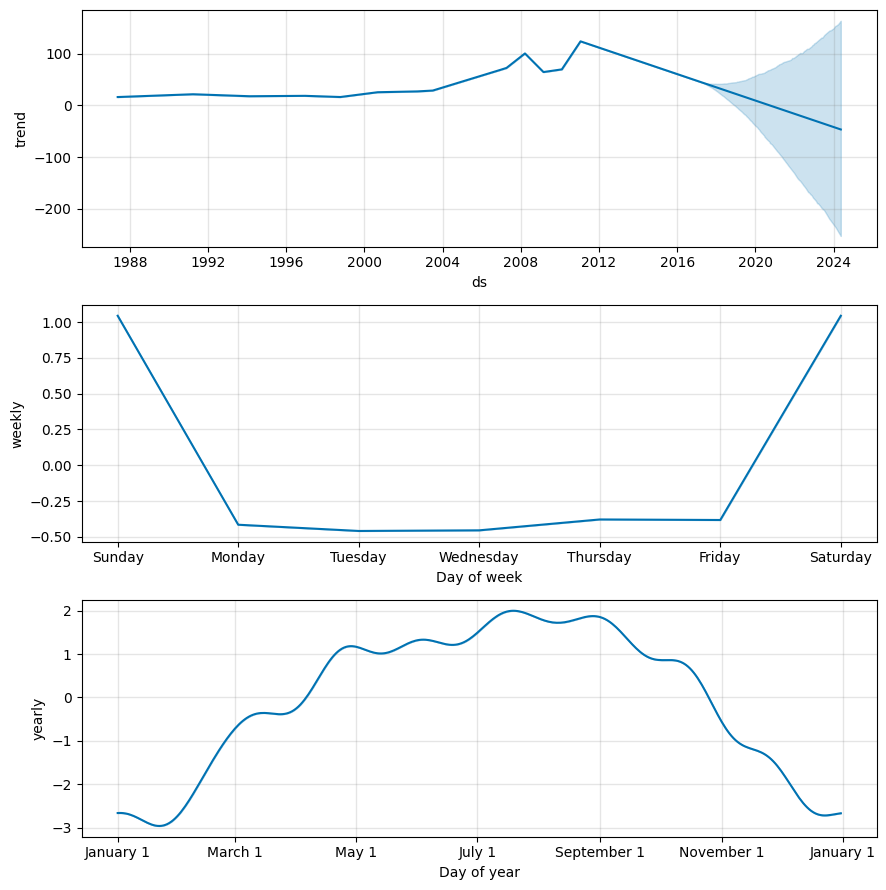

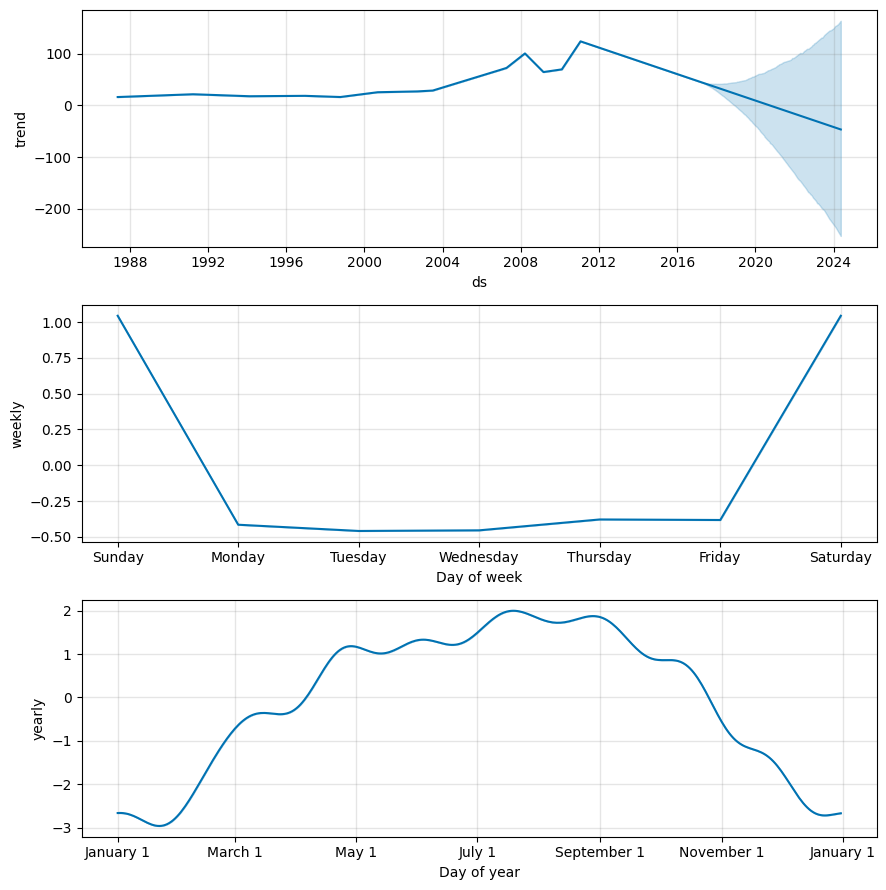

In [11]:
# baseline model
baseline_model = Prophet() # parâmetros default
baseline_model.fit(baseline_train)

# predizer test set
future_baseline = baseline_model.make_future_dataframe(periods=len(baseline_test),
                                                        freq='B') # dias úteis


forecast_baseline = baseline_model.predict(future_baseline)
forecast_baseline.loc[forecast_baseline['ds'] < baseline_test['ds'].min(), 'yhat'] = np.nan

# plotar baseline
fig = plot_plotly(baseline_model, forecast_baseline)
fig.update_layout(title='Baseline Model')
fig.show()

# plotar componentes
baseline_model.plot_components(forecast_baseline)

In [12]:
# salvar futuro e modelo
forecast_baseline.to_parquet(r'data\prophet_baseline_forecast.parquet')

with open(r'models\prophet_baseline_model.json', 'w') as f:
    json.dump(model_to_json(baseline_model), f)

with open(r'models\prophet_baseline_model.pkl', 'wb') as f:
    pickle.dump(baseline_model, f)

In [13]:
# cross validation
df_cv_baseline = cross_validation(baseline_model,
                                    initial='200 days',
                                    period='60 days',
                                    horizon='30 days')

# aplicar performance metrics para avaliar o modelo
df_p_baseline = performance_metrics(df_cv_baseline)

df_p_baseline.head(30)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/177 [00:00<?, ?it/s]11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:33 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/177 [00:00<00:18,  9.74it/s]11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:33 - cmdstanpy - INFO - Chain [1] done processing
11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:33 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 3/177 [00:00<00:16, 10.55it/s]11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:33 - cmdstanpy - INFO - Chain [1] done processing
11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:33 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 5/177 [00:00<00:17,  9.87it/s]11:46:34 - cmdstanpy - INFO - Chain [1] start processing
11:46:34 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 6/177 [00:00<00:19,  

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,231.834097,15.226099,8.903920,0.195310,0.117077,0.171469,0.489467
1,4 days,226.985230,15.066029,8.841158,0.193487,0.110704,0.171272,0.473625
2,5 days,236.900103,15.391559,9.089016,0.199441,0.119602,0.176899,0.440633
3,6 days,244.905467,15.649456,9.311579,0.205747,0.127811,0.183076,0.422164
4,7 days,246.017916,15.684958,9.436120,0.207382,0.133953,0.185689,0.416887
5,8 days,247.495670,15.731995,9.463218,0.207684,0.137943,0.185095,0.424802
6,9 days,256.395810,16.012364,9.554425,0.211766,0.135439,0.186749,0.419525
7,10 days,256.838395,16.026178,9.476819,0.213183,0.125756,0.187324,0.421054
8,11 days,254.426050,15.950738,9.398362,0.213101,0.125292,0.187793,0.423722
9,12 days,263.249478,16.224965,9.626579,0.218142,0.125292,0.192242,0.419525


In [14]:
# salvar rmse, mae e mape
df_p_baseline = df_p_baseline[['horizon', 'rmse', 'mae', 'mape']]

df_p_baseline.to_parquet(r'data\prophet_baseline_scores.parquet')

## Best Model - Grid Search

In [15]:
df = pd.read_parquet(r'data\data_w_indicators.parquet')

# remover 5 primeiras colunas, já que são sobre data e o modelo não precisa delas
df = df.drop(df.columns[0:6], axis=1)

# remover colunas com _diff e _pct
df = df.drop([col for col in df.columns if '_diff' in col or '_pct' in col], axis=1)

# remover macd_signal e macd_hist, pois derivam de macd
df = df.drop(['brent_macd_signal', 'brent_macd_hist'], axis=1)

# remover EMA para previnir overfitting
df = df.drop([col for col in df.columns if 'brent_ema' in col], axis=1)

# remover linhas com NaN
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9450 entries, 1988-02-23 to 2024-05-13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sp500       9450 non-null   float64
 1   exxon       9450 non-null   float64
 2   bp          9450 non-null   float64
 3   brent       9450 non-null   float64
 4   brent_rsi   9450 non-null   float64
 5   brent_macd  9450 non-null   float64
dtypes: float64(6)
memory usage: 516.8 KB


In [16]:
regressors = [col for col in df.columns if col != 'brent']

regressors = df[regressors].copy()

regressors

,sp500,exxon,bp,brent_rsi,brent_macd
date,,,,,
1988-02-23,265.019989,10.718750,13.718750,40.291494,-0.304675
1988-02-24,264.429993,10.562500,13.500000,37.018447,-0.314955
1988-02-25,261.579987,10.406250,13.656250,31.103223,-0.359305
1988-02-26,262.459991,10.312500,13.593750,29.100167,-0.405913
1988-02-29,267.820007,10.656250,13.281250,31.013954,-0.431421
...,...,...,...,...,...
2024-05-07,5187.700195,116.169998,37.580002,35.495504,-1.218507
2024-05-08,5187.669922,116.150002,37.529999,34.908648,-1.393547
2024-05-09,5214.080078,118.440002,38.040001,38.541620,-1.448595


In [17]:
# transformar dados para o prophet
df.index.name = 'ds'
df = df.reset_index(drop=False)

# brent to y
df = df.rename(columns={'brent': 'y'})

df = df[['ds', 'y'] + regressors.columns.tolist()]

df

,ds,y,sp500,exxon,bp,brent_rsi,brent_macd
0,1988-02-23,15.58,265.019989,10.718750,13.718750,40.291494,-0.304675
1,1988-02-24,15.35,264.429993,10.562500,13.500000,37.018447,-0.314955
2,1988-02-25,14.85,261.579987,10.406250,13.656250,31.103223,-0.359305
3,1988-02-26,14.65,262.459991,10.312500,13.593750,29.100167,-0.405913
4,1988-02-29,14.73,267.820007,10.656250,13.281250,31.013954,-0.431421
...,...,...,...,...,...,...,...
9445,2024-05-07,82.69,5187.700195,116.169998,37.580002,35.495504,-1.218507
9446,2024-05-08,82.44,5187.669922,116.150002,37.529999,34.908648,-1.393547
9447,2024-05-09,83.27,5214.080078,118.440002,38.040001,38.541620,-1.448595
9448,2024-05-10,83.39,5222.680176,117.959999,37.840000,39.071101,-1.465642


In [18]:
# 80% treino e 20% teste
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

print(f'Treino: {len(train)}')
print(f'Teste: {len(test)}')

Treino: 7560
Teste: 1890


In [19]:
# salvar treino e teste
train.to_parquet(r'data\prophet_final_train.parquet')
test.to_parquet(r'data\prophet_final_test.parquet')

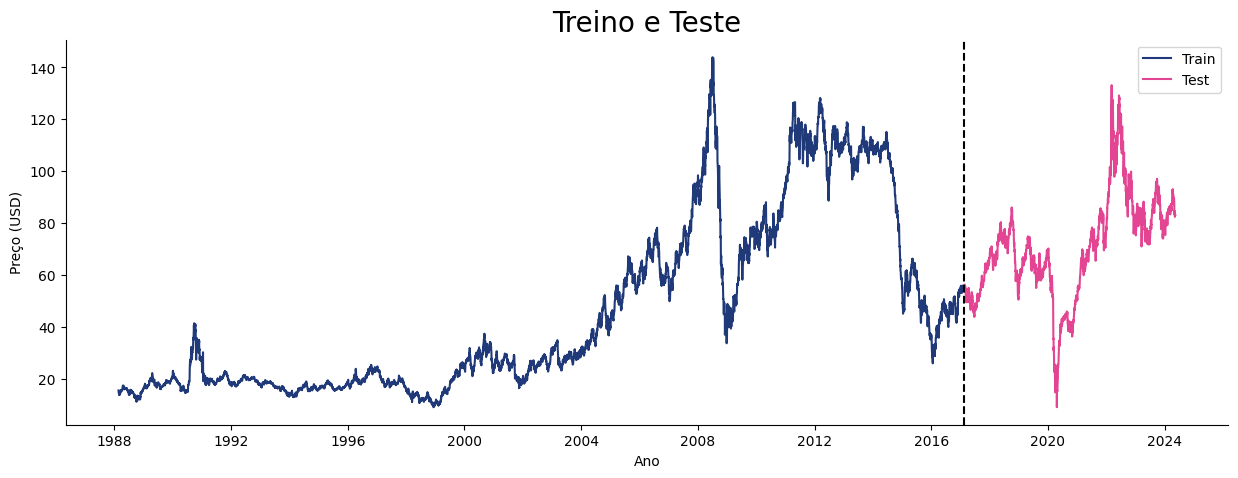

In [20]:
# plotar treino e teste
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], 
        train['y'], 
        label='Train', color='#1f3979')
ax.plot(test['ds'],
        test['y'],
        label='Test',
        color='#e34592')
ax.set_title('Treino e Teste', fontsize=20)
ax.set_xlabel('Ano')
ax.set_ylabel('Preço (USD)')
ax.axvline(x=test['ds'].min(), color='black', linestyle='--')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend();

In [21]:
param_grid = {
        'changepoint_prior_scale': np.linspace(0.001, 0.5, 3),
        'seasonality_prior_scale': np.linspace(0.01, 10, 3),
        'holidays_prior_scale': [0.1, 10],
    }

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

all_params

[{'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 10},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 5.005,
  'holidays_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 5.005,
  'holidays_prior_scale': 10},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 10},
 {'changepoint_prior_scale': 0.2505,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.2505,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 10},
 {'changepoint_prior_scale': 0.2505,
  'seasonality_prior_scale': 5.005,
  'holidays_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.2505,
  'seasonality_prior_scale': 5.005

In [22]:
results = []
periods=252

for i, params in enumerate(all_params):
    model = Prophet(**params)
    # add regressors
    for regressor in regressors.columns:
        model.add_regressor(regressor)
    # add holidays
    model.add_country_holidays(country_name='US')
    # fit model
    model.fit(train)
     # make future dataframe
    future = model.make_future_dataframe(periods=periods, 
                                         freq='B', 
                                         include_history=True)
    # add regressors
    for regressor in regressors.columns:
        future[regressor] = df[regressor]
    # predict
    forecast = model.predict(future)
    # predictions
    predictions = forecast[['ds', 'yhat']].tail(periods)
    # calculate the error mape
    error = mape(df['y'], forecast['yhat'])
    # append the results
    results.append([params, error])
    
results = pd.DataFrame(results, columns=['params', 'mape'])
results = results.sort_values('mape', ascending=True)

11:48:55 - cmdstanpy - INFO - Chain [1] start processing
11:48:55 - cmdstanpy - INFO - Chain [1] done processing
11:48:57 - cmdstanpy - INFO - Chain [1] start processing
11:48:57 - cmdstanpy - INFO - Chain [1] done processing
11:48:58 - cmdstanpy - INFO - Chain [1] start processing
11:48:58 - cmdstanpy - INFO - Chain [1] done processing
11:48:59 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
11:49:01 - cmdstanpy - INFO - Chain [1] start processing
11:49:01 - cmdstanpy - INFO - Chain [1] done processing
11:49:02 - cmdstanpy - INFO - Chain [1] start processing
11:49:02 - cmdstanpy - INFO - Chain [1] done processing
11:49:04 - cmdstanpy - INFO - Chain [1] start processing
11:49:08 - cmdstanpy - INFO - Chain [1] done processing
11:49:09 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing
11:49:14 - cmdstanpy - INFO - Chain [1] start processing
11:49:18 - cmdstanpy - INFO - Chain [1]

In [23]:
best_params = results.iloc[0, 0]

best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.01,
 'holidays_prior_scale': 0.1}

In [24]:
# criar modelo a partir dos melhores parâmetros
best_model = Prophet(**best_params)
# adicionar regressores
for regressor in regressors.columns:
    best_model.add_regressor(regressor)
# adicionar feriados
best_model.add_country_holidays(country_name='US')
# treinar modelo
best_model.fit(train)

# cross validation
df_cv = cross_validation(best_model,
                         initial='200 days',
                         period='60 days',
                         horizon='30 days')

# aplicar performance metrics para avaliar o modelo
df_p = performance_metrics(df_cv)

df_p.head(30)

11:50:05 - cmdstanpy - INFO - Chain [1] start processing
11:50:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/173 [00:00<?, ?it/s]11:50:10 - cmdstanpy - INFO - Chain [1] start processing
11:50:10 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/173 [00:00<00:37,  4.55it/s]11:50:10 - cmdstanpy - INFO - Chain [1] start processing
11:50:10 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/173 [00:00<00:38,  4.43it/s]11:50:10 - cmdstanpy - INFO - Chain [1] start processing
11:50:10 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 3/173 [00:00<00:42,  3.98it/s]11:50:11 - cmdstanpy - INFO - Chain [1] start processing
11:50:11 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/173 [00:00<00:42,  3.99it/s]11:50:11 - cmdstanpy - INFO - Chain [1] start processing
11:50:11 - cmdstanpy - INFO - Chain [1] done pr

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,115.187501,10.732544,6.140272,0.121139,0.071860,0.112206,0.397297
1,4 days,116.496728,10.793365,6.175015,0.121904,0.071644,0.112657,0.380114
2,5 days,113.841164,10.669637,6.146226,0.120802,0.072359,0.112602,0.377332
3,6 days,111.934961,10.579932,6.101133,0.120260,0.074336,0.112329,0.385418
4,7 days,103.798860,10.188173,5.913003,0.116109,0.073781,0.109095,0.393650
5,8 days,100.197088,10.009850,5.854087,0.115314,0.074205,0.109000,0.390780
6,9 days,114.072889,10.680491,6.274575,0.123245,0.075551,0.116343,0.348649
7,10 days,131.531929,11.468737,6.729069,0.132179,0.080665,0.124507,0.313514
8,11 days,136.028183,11.663112,6.810690,0.132402,0.081358,0.124891,0.315447
9,12 days,134.358745,11.591322,6.709250,0.130794,0.081686,0.123377,0.328880


In [25]:
# comparar baseline e final - calcular melhora dentro do horizonte de 3 dias
df_p_baseline = pd.read_parquet(r'data\prophet_baseline_scores.parquet')
df_p_baseline = df_p_baseline[df_p_baseline['horizon'] == '3 days']

df_p_final = df_p[df_p['horizon'] == '3 days']

df_p_baseline = df_p_baseline.rename(columns={'rmse': 'rmse_baseline',
                                                'mae': 'mae_baseline',
                                                'mape': 'mape_baseline'})

df_p_final = df_p_final.rename(columns={'rmse': 'rmse_final',
                                        'mae': 'mae_final',
                                        'mape': 'mape_final'})

# resetar index de ambos os dataframes
df_p_baseline = df_p_baseline.reset_index(drop=True)
df_p_final = df_p_final.reset_index(drop=True)

# calcular melhora em %
df_p_baseline['rmse_improvement'] = (df_p_baseline['rmse_baseline'] - df_p_final['rmse_final']) / \
                                                    df_p_baseline['rmse_baseline'] * 100
df_p_baseline['mae_improvement'] = (df_p_baseline['mae_baseline'] - df_p_final['mae_final']) /    \
                                                    df_p_baseline['mae_baseline'] * 100
df_p_baseline['mape_improvement'] = (df_p_baseline['mape_baseline'] - df_p_final['mape_final']) / \
                                                    df_p_baseline['mape_baseline'] * 100

df_p_baseline

,horizon,rmse_baseline,mae_baseline,mape_baseline,rmse_improvement,mae_improvement,mape_improvement
0,3 days,15.226099,8.90392,0.19531,29.512189,31.038555,37.976027


In [26]:
# salvar modelo
with open(r'models\prophet_final_model.json', 'w') as f:
    json.dump(model_to_json(best_model), f)

with open(r'models\prophet_final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [27]:
# salvar rmse, mae e mape
df_p = df_p[['horizon', 'rmse', 'mae', 'mape']]
df_p.to_parquet(r'data\prophet_final_scores.parquet')

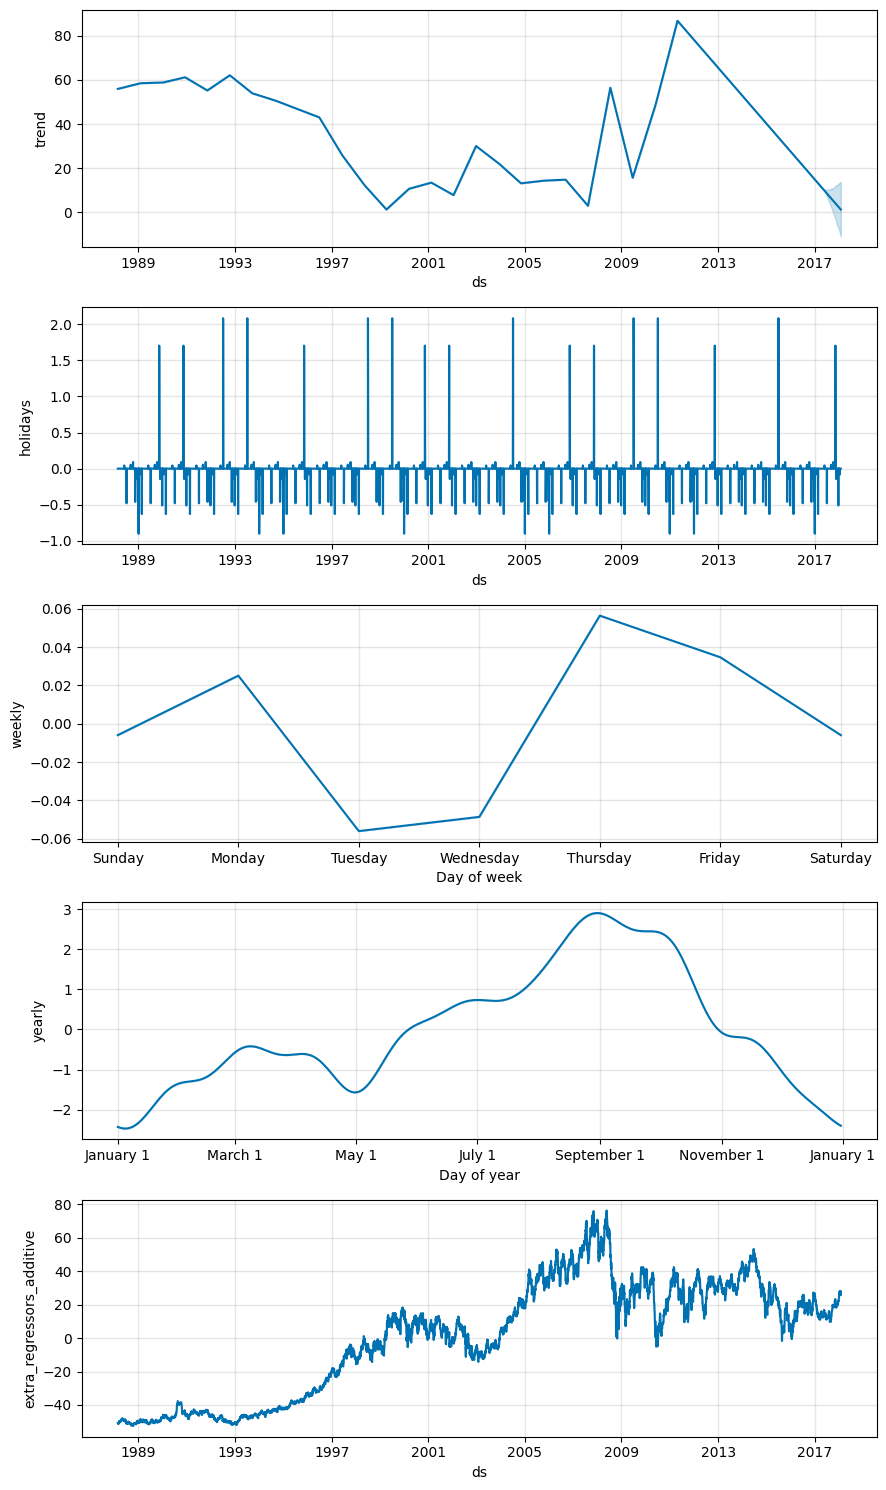

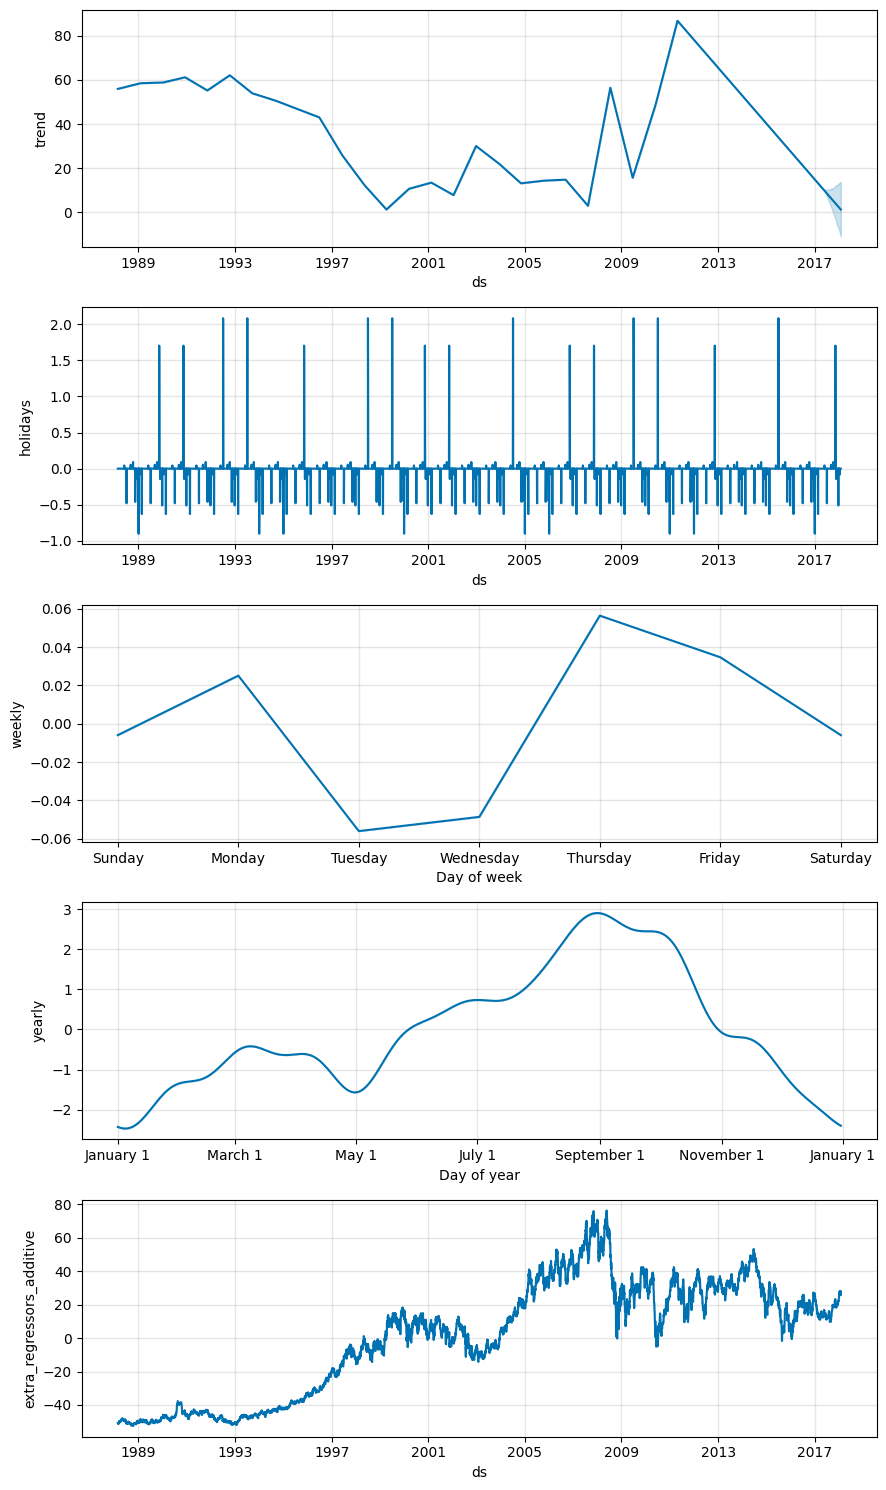

In [28]:
# plotar componentes
best_model.plot_components(forecast)

In [29]:
# plotar previsão vs. real com plotly - dados futuros
future = best_model.make_future_dataframe(periods=len(test),
                                            freq='D')

for regressor in regressors.columns:
    future[regressor] = df[regressor]

forecast = best_model.predict(future)
forecast = forecast.merge(test[['ds', 'y']], on='ds')

fig = plot_plotly(best_model, forecast)
fig.update_layout(title='Best Model')
fig.show()

In [30]:
# exportar previsões
forecast.to_parquet(r'data\prophet_final_forecast.parquet')

In [31]:
# salvar modelo em json e pickle
with open('models/prophet_model.json', 'w') as file:
    json.dump(model_to_json(best_model), file)
    
with open('models/prophet_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)